In [1]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from typing import List, Tuple
import torch.nn.functional as F
import torch
from PIL import Image
from transformers import AutoProcessor, AutoModel
from typing import Union, List

/home/student1/miniconda3/envs/testing_llmbackend/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class JinaRetriever:
    """Simple retrieval using Jina CLIP model"""
    def __init__(self, model_name: str = "jinaai/jina-clip-v2", device: str = "cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        self.processor = AutoProcessor.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)

    def get_text_embeddings(self,
                           texts: Union[str, List[str]],
                           normalize: bool = True,
                           output_dim: int = None) -> torch.Tensor:
        """
        Extract text embeddings from input texts.
        """
        inputs = self.processor(text=texts, return_tensors="pt", padding=True)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            text_features = self.model.get_text_features(**inputs)

        if normalize:
            text_features = torch.nn.functional.normalize(text_features, dim=-1)

        if output_dim is not None:
            text_features = text_features[:, :output_dim]

        # Convert to float32 for compatibility
        return text_features.cpu().float()

    def get_image_embeddings(self,
                            images: Union[Image.Image, List[Image.Image]],
                            normalize: bool = True,
                            output_dim: int = None) -> torch.Tensor:
        """
        Extract image embeddings from input images.
        """
        inputs = self.processor(images=images, return_tensors="pt")
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            image_features = self.model.get_image_features(**inputs)

        if normalize:
            image_features = torch.nn.functional.normalize(image_features, dim=-1)

        if output_dim is not None:
            image_features = image_features[:, :output_dim]

        # Convert to float32 for compatibility
        return image_features.cpu().float()

    def find_similar_texts(self, query: str, texts: List[str], k: int = 5) -> Tuple[List[str], List[float]]:
        """Find k most similar texts to query"""
        query_embedding = self.get_text_embeddings([query])
        text_embeddings = self.get_text_embeddings(texts)

        similarities = torch.mm(query_embedding, text_embeddings.t()).squeeze()
        top_k = torch.topk(similarities, min(k, len(texts)))

        results = [texts[idx] for idx in top_k.indices]
        scores = top_k.values.tolist()
        return results, scores

    def find_similar_images(self, query: str, images: List[Image.Image], k: int = 5) -> Tuple[List[int], List[float]]:
        """Find k most similar images to text query"""
        query_embedding = self.get_text_embeddings([query])
        image_embeddings = self.get_image_embeddings(images)

        similarities = torch.mm(query_embedding, image_embeddings.t()).squeeze()
        top_k = torch.topk(similarities, min(k, len(images)))

        return top_k.indices.tolist(), top_k.values.tolist()


In [3]:
texts = [
    "a dog running in the park",
    "a cat sleeping on a couch",
    "birds flying in the sky",
    "a child playing with a ball",
    "a car driving down the road",
    "a person eating a meal",
    "a group of people dancing",
    "a sunset over the ocean",
    "a forest with tall trees",
    "a city with skyscrapers",
    "a beautiful flower garden",
    "a delicious plate of food",
    "a cozy living room",
    "a modern kitchen",
    "a spacious bedroom",
    "a busy office",
    "a crowded street",
    "a peaceful park",
    "a serene lake",
    "a majestic mountain",
    "a wild animal in its habitat",
    "a domestic animal playing",
    "a funny cartoon character",
    "a scary monster movie",
    "a romantic love story",
    "a thrilling action movie",
    "a thought-provoking documentary",
    "a catchy pop song",
    "a relaxing classical music",
    "an exciting sports game"
]

In [4]:
retriever = JinaRetriever()  # or OpenCLIPRetriever()

/home/student1/miniconda3/envs/testing_llmbackend/lib/python3.10/site-packages/flash_attn/ops/triton/layer_norm.py:985: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/home/student1/miniconda3/envs/testing_llmbackend/lib/python3.10/site-packages/flash_attn/ops/triton/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout, *args):


In [5]:
query = "sunset"

similar_texts, scores = retriever.find_similar_texts(query, texts, k=20)
print("Similar texts:", similar_texts)
print("Similarity scores:", scores)

Similar texts: ['a sunset over the ocean', 'a majestic mountain', 'a serene lake', 'a peaceful park', 'a romantic love story', 'a relaxing classical music', 'birds flying in the sky', 'an exciting sports game', 'a car driving down the road', 'a catchy pop song', 'a city with skyscrapers', 'a beautiful flower garden', 'a crowded street', 'a thrilling action movie', 'a spacious bedroom', 'a wild animal in its habitat', 'a modern kitchen', 'a cozy living room', 'a delicious plate of food', 'a group of people dancing']
Similarity scores: [0.771100640296936, 0.4957750737667084, 0.46810030937194824, 0.45795100927352905, 0.45224589109420776, 0.4131459891796112, 0.4043750762939453, 0.4030463397502899, 0.40106403827667236, 0.3999790549278259, 0.39010483026504517, 0.3846728205680847, 0.3694848418235779, 0.3613474369049072, 0.3535727262496948, 0.3491608798503876, 0.347528874874115, 0.3450780510902405, 0.3420126140117645, 0.33692359924316406]


see the maximum number of images

In [6]:
import json

# Load the JSON data from a file
with open("/home/student1/langchain/testing/new_idea/ImageData/hiking_data_20250119_125520.json", "r") as f:
    data = json.load(f)

# Find the id with the maximum number of images
max_images = 0
max_images_id = None
for obj in data:
    if "images" in obj and len(obj["images"]) > max_images:
        max_images = len(obj["images"])
        max_images_id = obj.get("tour_id")  # Assuming "tour_id" is the id key

# Print the result
if max_images_id:
    print(f"The id with the maximum number of images is: {max_images_id}")
    print(f"It has {max_images} images.")
else:
    print("No objects with images found in the JSON data.")

The id with the maximum number of images is: 42787855
It has 67 images.


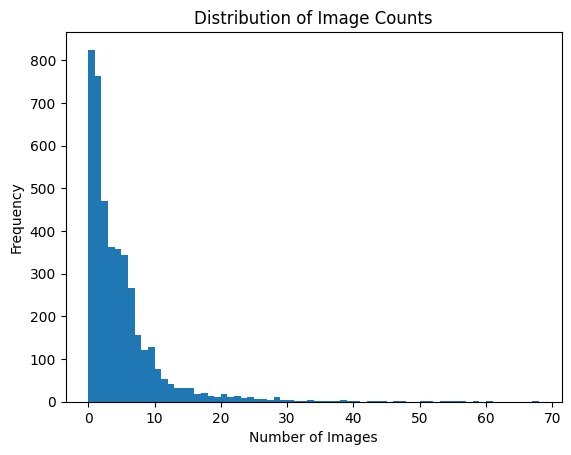

In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np
# Load the JSON data from a file
with open("/home/student1/langchain/testing/new_idea/ImageData/hiking_data_20250119_125520.json", "r") as f:
    data = json.load(f)

# Extract the number of images for each object
image_counts = [len(obj.get("images", [])) for obj in data]

# Create the histogram
plt.hist(image_counts, bins=range(max(image_counts) + 2))  # Add 2 to include the last bin
plt.xlabel("Number of Images")
plt.ylabel("Frequency")
plt.title("Distribution of Image Counts")
plt.show()

llm selector

In [1]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
# default: Load the model on the available device(s)
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
# )

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)
# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

/home/student1/miniconda3/envs/testing_llmbackend/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46
Loading checkpoint shards: 100%|██████████| 5/5 [00:02<00:00,  2.46it/s]


In [3]:
import json
import torch
from typing import List, Dict, Any
import datetime
import re

def clean_json_string(text: str) -> str:
    """
    Clean and extract JSON from model output text.
    """
    # Find text that looks like JSON array
    json_match = re.search(r'\[[\s\S]*\]', text)
    if json_match:
        potential_json = json_match.group()
        try:
            # Validate it's proper JSON by parsing it
            json.loads(potential_json)
            return potential_json
        except json.JSONDecodeError:
            pass
    
    # If no valid JSON array found, try to fix common issues
    # Remove any text before the first [
    text = text[text.find('['):] if '[' in text else text
    # Remove any text after the last ]
    text = text[:text.rfind(']')+1] if ']' in text else text
    
    return text
def create_image_analysis_prompt() -> str:
    """
    Creates a prompt for analyzing trekking images to select the best cover photo.
    """
    prompt = """You are an expert trek photographer analyzing images to select the most inspiring cover photo.
    Evaluate each image based on:

    1. Technical Quality :
    - Sharpness and clarity
    - Dynamic range
    - No motion blur or focus issues
    - Weather visibility and lighting

    2. Trek Appeal :
    - see as if you go on the trek which landscape out of the following image would you like for your travel
    - visually apealling  
    - Landscape drama (mountains, valleys, forests)
    - Adventure factor

    Critical Requirements:
    - Favor dramatic landscapes that inspire trekking

    Provide JSON response for every image like this!!!:
    {
        {
            "image_index": int,
            "technical_score": float (0-1),
            "trek_appeal_score": float (0-1),
            "reasoning": {
                "technical_quality": str,
                "trek_appeal": str
            },
            "overall_score": float (0-1)
        }
        ...
        ...
    }
    """
    return prompt

def process_image_batch(images: List[str],model: Any,processor: Any) -> Dict:
    """
    Process a batch of images with user preferences context.
    """
    messages = [{
        "role": "user",
        "content": [
            {"type": "image", "image": img} for img in images
        ] + [{"type": "text", "text": create_image_analysis_prompt()}]
    }]
    
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )
    
    return inputs

def select_best_image(image_paths: List[str], model: Any, processor: Any, max_retries: int = 3) -> Dict[str, Any]:
    """
    Select the best image with retry logic for JSON parsing errors.
   
    Args:
        image_paths: List of paths to images
        model: The multimodal model
        processor: The image processor
        max_retries: Maximum number of retry attempts for JSON parsing
       
    Returns:
        Dictionary containing the selected image and its analysis, or None if failed
    """
    for attempt in range(max_retries):
        try:
            inputs = process_image_batch(images=image_paths,
                                    model=model, processor=processor)
        
            # Move to GPU if available
            device = "cuda" if torch.cuda.is_available() else "cpu"
            inputs = inputs.to(device)
        
            # Generate analysis
            with torch.no_grad():
                output_ids = model.generate(**inputs, max_new_tokens=2046)
                output_text = processor.batch_decode(
                    output_ids[:, inputs.input_ids.shape[1]:],
                    skip_special_tokens=True
                )
            
            cleaned_json_str = clean_json_string(output_text[0])
            print("#"*40)
            print(f"Attempt {attempt + 1} of {max_retries}")
            print(cleaned_json_str)
            print("#"*40)
            
            try:
                results = json.loads(cleaned_json_str)
                
                # Validate results structure
                if not isinstance(results, list):
                    print(f"Invalid results format (not a list) on attempt {attempt + 1}")
                    if attempt == max_retries - 1:
                        return {"path": image_paths[0], "weighted_score": 0}
                    continue

                # Score each image considering multiple factors
                scored_images = []
                print("*"*40)
                
                for index, result in enumerate(results):
                    try:
                            
                        weighted_score = (
                            result["technical_score"] * 0.4 +
                            result["trek_appeal_score"] * 0.6
                        )
                        
                        # Verify image_index is valid
                        img_index = result["image_index"] - 1
                        if 0 <= img_index < len(image_paths):
                            scored_images.append({
                                "path": image_paths[img_index],
                                "weighted_score": weighted_score
                            })
                            print(f"Scored image {index}: {scored_images[-1]}")
                        else:
                            print(f"Invalid image_index {img_index} for result {index}")
                            
                    except Exception as e:
                        print(f"Error processing result {index}: {str(e)}")
                        continue

                # Select the image with the highest weighted score
                if scored_images:
                    best_image = max(scored_images, key=lambda x: x["weighted_score"])
                    return best_image
                
                # If no valid scored images, but not last attempt
                if attempt < max_retries - 1:
                    print("No valid scored images, retrying...")
                    continue
                
                # If last attempt and no valid scores, return first image with 0 score
                return {"path": image_paths[0], "weighted_score": 0}

            except json.JSONDecodeError as e:
                print(f"JSON decode error on attempt {attempt + 1}: {str(e)}")
                if attempt == max_retries - 1:
                    return {"path": image_paths[0], "weighted_score": 0}
                continue
                
        except Exception as e:
            print(f"Unexpected error on attempt {attempt + 1}: {str(e)}")
            if attempt == max_retries - 1:
                return {"path": image_paths[0], "weighted_score": 0}
            continue

    # If all retries failed, return first image with 0 score
    return {"path": image_paths[0], "weighted_score": 0}

In [3]:
best_image = select_best_image(
    image_paths=['https://img1.oastatic.com/img2/17943292/640x360c/variant.jpg', 'https://img2.oastatic.com/img2/17941903/640x360c/variant.jpg', 'https://c8.alamy.com/comp/2AAM0BG/bulletin-board-and-map-of-hiking-trails-at-appalachia-trailhead-in-randolph-new-hampshire-usa-2AAM0BG.jpg'],
    model=model,
    processor=processor
)

########################################
Attempt 1 of 3
[
    {
        "image_index": 1,
        "technical_score": 0.9,
        "trek_appeal_score": 0.9,
        "reasoning": {
            "technical_quality": "The image has good sharpness and clarity, with a wide dynamic range. The weather visibility is excellent, and the lighting is well-balanced.",
            "trek_appeal": "This image has a dramatic landscape with towering mountains and a sense of adventure. The visual appeal is strong, making it an inspiring choice for a trek."
        },
        "overall_score": 0.9
    },
    {
        "image_index": 2,
        "technical_score": 0.9,
        "trek_appeal_score": 0.8,
        "reasoning": {
            "technical_quality": "The image has excellent sharpness and clarity, with a wide dynamic range. The weather visibility is good, and the lighting is well-balanced.",
            "trek_appeal": "This image has a dramatic landscape with a mix of rocky terrain and clouds, adding to

In [4]:
best_image

{'path': 'https://img1.oastatic.com/img2/17943292/640x360c/variant.jpg',
 'weighted_score': 0.9000000000000001}

best image selector

In [4]:
CHUNK_SIZE=4

In [5]:
import math
from typing import List, Dict, Any
import copy

def chunk_list(lst: List[Any], chunk_size: int) -> List[List[Any]]:
    """Split a list into chunks of specified size"""
    return [lst[i:i + chunk_size] for i in range(0, len(lst), chunk_size)]

def process_tournament_round(image_groups: List[List[str]], 
                           model: Any,
                           processor: Any) -> List[Dict[str, Any]]:
    """Process one round of the tournament"""
    winners = []
    for image_group in image_groups:
        if len(image_group) > 0:
            best_image = select_best_image(
                image_paths=image_group,
                model=model,
                processor=processor
            )
            if best_image:
                winners.append(best_image)
    return winners

def select_best_image_tournament(images: List[Dict[str, Any]], 
                               model: Any,
                               processor: Any) -> Dict[str, Any]:
    """
    Select the best image using a tournament approach.
    
    Args:
        images: List of image dictionaries containing 'url' field
        model: The multimodal model
        processor: The image processor
    
    Returns:
        Dictionary containing the winning image URL and its score
    """
    if not images:
        return None
        
    # Extract image URLs
    image_urls = [img['url'] for img in images]
    
    # If only one image, process it directly
    if len(image_urls) == 1:
        return {'path':image_urls[0] ,'weighted_score': 0.84}
    
    # Split images into groups of 4
    current_round = chunk_list(image_urls, chunk_size=CHUNK_SIZE)
    
    # Continue tournament until we have a winner
    while len(current_round) > 1 or (len(current_round) == 1 and len(current_round[0]) > 1):
        winners = process_tournament_round(
            current_round,
            model,
            processor
        )
        current_round = chunk_list(
            [winner['path'] for winner in winners],
            CHUNK_SIZE
        )
    
    # Return the final winner
    if current_round and current_round[0]:
        final_result = select_best_image(
            image_paths=current_round[0],
            model=model,
            processor=processor
        )
        return final_result
    return None

In [6]:
import json
import os
from datetime import datetime
import copy
from typing import List, Dict, Any

def save_processed_data(data: List[Dict], filename: str):
    """Save processed data to JSON file"""
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

def rotate_save_files(base_filename: str):
    """Rotate save files, keeping only current and backup"""
    # Remove old backup if exists
    if os.path.exists(f"{base_filename}_backup.json"):
        os.remove(f"{base_filename}_backup.json")
    
    # Rename current to backup if exists
    if os.path.exists(f"{base_filename}_current.json"):
        os.rename(f"{base_filename}_current.json", f"{base_filename}_backup.json")

def process_tour_data(tour_data: List[Dict[str, Any]],
                     model: Any,
                     processor: Any,
                     save_rate:int,
                     base_filename: str = "processed_tours") -> List[Dict[str, Any]]:
    """
    Process all tour data and select best cover images.
    Saves progress every 100 items and maintains two save files.
   
    Args:
        tour_data: List of tour dictionaries
        model: The multimodal model
        processor: The image processor
        base_filename: Base name for save files
   
    Returns:
        Updated tour data with best cover images
    """
    processed_data = []
    
    total_items = len(tour_data)
    
    for index, tour in enumerate(tour_data):
        # Make a deep copy to avoid modifying original
        tour_copy = copy.deepcopy(tour)
        
        # Handle cover image selection
        if tour_copy.get('images'):
            best_image = select_best_image_tournament(
                tour_copy['images'],
                model,
                processor
            )
            
            if best_image:
                tour_copy['cover_image'] = {
                    'url': best_image['path'],
                    'score': best_image['weighted_score']
                }
        else:
            # Use map_url as fallback with fixed score
            if tour_copy.get('map_url'):
                tour_copy['cover_image'] = {
                    'url': tour_copy['map_url'],
                    'score': 0.7
                }
        
        processed_data.append(tour_copy)
        
        # Save every 100 items
        if (index + 1) % save_rate == 0:
            print(f"Processed {index + 1}/{total_items} items")
            rotate_save_files(base_filename)
            save_processed_data(processed_data, f"{base_filename}_current.json")
    
    # Final save
    rotate_save_files(base_filename)
    save_processed_data(processed_data, f"{base_filename}_current.json")
    
    return processed_data

def load_latest_processed_data(base_filename: str) -> List[Dict[str, Any]]:
    """
    Load the most recent processed data file.
    Useful for resuming processing after interruption.
    """
    current_file = f"{base_filename}_current.json"
    backup_file = f"{base_filename}_backup.json"
    
    if os.path.exists(current_file):
        with open(current_file, 'r', encoding='utf-8') as f:
            return json.load(f)
    elif os.path.exists(backup_file):
        with open(backup_file, 'r', encoding='utf-8') as f:
            return json.load(f)
    return []

def resume_processing(tour_data: List[Dict[str, Any]],
                     model: Any,
                     processor: Any,
                     save_rate:int,
                     base_filename: str = "processed_tours") -> List[Dict[str, Any]]:
    """
    Resume processing from the last saved state.
    """
    processed_data = load_latest_processed_data(base_filename)
    
    # Find where we left off
    processed_ids = {tour['tour_id'] for tour in processed_data}
    remaining_data = [tour for tour in tour_data if tour['tour_id'] not in processed_ids]
    
    if not remaining_data:
        return processed_data
    
    print(f"Resuming processing from item {len(processed_data) + 1}")
    return process_tour_data(remaining_data, model, processor,save_rate, base_filename)

In [7]:
import json

# Load JSON from a file
with open('/home/student1/langchain/testing/new_idea/ImageData/ImageEmbedder/part_1.json', 'r') as f:
  data = json.load(f)

In [ ]:
# For new processing
processed_tours = resume_processing(
    tour_data=data,
    model=model,
    processor=processor,
    save_rate=1,
    base_filename="my_tours"  # optional, defaults to "processed_tours"
)

Resuming processing from item 1125
########################################
Attempt 1 of 3
[
    {
        "image_index": 1,
        "technical_score": 0.9,
        "trek_appeal_score": 0.9,
        "reasoning": {
            "technical_quality": "The image has good sharpness and clarity, with a wide dynamic range. There is no motion blur or focus issues, and the weather visibility is clear with good lighting.",
            "trek_appeal": "This image has a dramatic landscape with mountains, valleys, and forests. The adventure factor is high, making it an inspiring choice for a trekking cover photo."
        },
        "overall_score": 0.9
    },
    {
        "image_index": 2,
        "technical_score": 0.9,
        "trek_appeal_score": 0.9,
        "reasoning": {
            "technical_quality": "The image has good sharpness and clarity, with a wide dynamic range. There is no motion blur or focus issues, and the weather visibility is clear with good lighting.",
            "trek_appea